In [60]:
!pip install nxviz=='0.6.3'

In [61]:
!pip install -U pandas-profiling

In [62]:
import networkx as nx
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas as pd
import json
from scipy.sparse import csr_matrix

#1.Dataset - Download 


In [63]:
#Read in json splice and transform into a playlist level dataframe
start = 0
end = 1000
path = 'sample_data/mpd.slice.' + str(start) + "-" + str(end-1) + '.json'
d = json.load(open(path, 'r'))
df = pd.DataFrame.from_dict(d['playlists'], orient='columns')

In [64]:
#Turn playlist level dataframe into song level dataframe
songPlaylistArray = []
for index, row in df.iterrows():
    for track in row['tracks']:
        songPlaylistArray.append([track['track_uri'], track['artist_name'], track['track_name'], row['pid']])
songPlaylist = pd.DataFrame(songPlaylistArray, columns=['trackid', 'artist_name', 'track_name', 'pid'])

print(songPlaylist.shape)
songPlaylist.head(10)  
#is a df of all track ids, cooresponding artist names, track names and playlist ids

(67503, 4)


,trackid,artist_name,track_name,pid
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),0
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,0
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love,0
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,0
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,0
5,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Usher,Yeah!,0
6,spotify:track:68vgtRHr7iZHpzGpon6Jlo,Usher,My Boo,0
7,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,The Pussycat Dolls,Buttons,0
8,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Destiny's Child,Say My Name,0
9,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,OutKast,Hey Ya! - Radio Mix / Club Mix,0


Extraindo os dados necessários para o estudo da rede.


In [65]:
def extract_features(df):
  playlistsAndTracks = []
  for _, row in df.iterrows():
    for track in row["tracks"]:
      playlistsAndTracks.append([row['pid'], row["name"], track["track_uri"], row["num_tracks"], track["album_name"], track['artist_name'].replace('$',''),track['track_name']])
  return pd.DataFrame(playlistsAndTracks, columns = ['pid', 'name', 'track_id', 'num_tracks', 'album_name', 'artist_name', 'track_name'])
    

In [66]:
df_playlistsAndTracks = extract_features(df.iloc[:20,:])

In [67]:
df_playlistsAndTracks.sample(5)

,pid,name,track_id,num_tracks,album_name,artist_name,track_name
366,5,Wedding,spotify:track:5j9iuo3tMmQIfnEEQOOjxh,80,"Oh, What A Life",American Authors,Best Day Of My Life
1133,19,melancholy,spotify:track:6RFCBfneSaZoHPJ3wu3wT4,85,Asleep At Heaven's Gate,Rogue Wave,Lake Michigan
860,16,slow hands,spotify:track:3axgqGqkHevsTI9mQLecD7,105,✝✝✝ (Crosses),✝✝✝ (Crosses),Prurient
152,2,korean,spotify:track:5SE57ljOIUJ1ybL9U6CuBH,64,Love Yourself 承 'Her',BTS,DNA
1120,19,melancholy,spotify:track:60ZGteAEtPCnGE6zevgUcd,85,My Head Is An Animal,Of Monsters and Men,Mountain Sound


In [68]:
df_playlistsAndTracks[df_playlistsAndTracks["pid"]==1].groupby(['artist_name'])["track_id"].count().reset_index(name = "occurrences")

,artist_name,occurrences
0,Ben Foster,2
1,Boston,3
2,Christopher Jackson,1
3,Collective Soul,1
4,Creedence Clearwater Revival,1
5,Daniel Tidwell,6
6,Guns N' Roses,1
7,Kaleptik,1
8,Kansas,1
9,Led Zeppelin,2


In [69]:
df_playlistsAndTracks

,pid,name,track_id,num_tracks,album_name,artist_name,track_name
0,0,Throwbacks,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,52,The Cookbook,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop)
1,0,Throwbacks,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,52,In The Zone,Britney Spears,Toxic
2,0,Throwbacks,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,52,Dangerously In Love (Alben für die Ewigkeit),Beyoncé,Crazy In Love
3,0,Throwbacks,spotify:track:1AWQoqb9bSvzTjaLralEkT,52,Justified,Justin Timberlake,Rock Your Body
4,0,Throwbacks,spotify:track:1lzr43nnXAijIGYnCT8M8H,52,Hot Shot,Shaggy,It Wasn't Me
...,...,...,...,...,...,...,...
1184,19,melancholy,spotify:track:24M81fKyhTWBuYzczQMkOp,85,Bryter Layter,Nick Drake,One Of These Things First
1185,19,melancholy,spotify:track:5yGVHzJ2Se8pDzR7FIYUlU,85,Home Again,Michael Kiwanuka,Home Again
1186,19,melancholy,spotify:track:1239baQ1b9cD0RRv5Jy9Sb,85,I'm Not There (Music From The Motion Picture),Jim James & Calexico,Goin' to Acapulco
1187,19,melancholy,spotify:track:1lzVrQWoBJeEtGDcUHO73O,85,Notions - EP,Leo Stannard,Please Don't


In [70]:
def get_weight_in_edge(node1, node2, G):
  try: 
    return G.edges[node1, node2]["weight"]
  except:
    return 0.0

In [71]:
def make_graph(df):
  G = nx.Graph()
  #coleta o id para realizar o pivoteamento 
  for pid in df["pid"].unique():
    #Pivoteamento de apenas uma playlist por vez 
    df_actual_pid = df[df["pid"]==pid]
    df_artists_count = df_actual_pid.groupby(["artist_name"])["track_id"].count().reset_index(name="occurrences")
    #Adiciona os Nodes da vez 
    G.add_nodes_from(df_artists_count["artist_name"].values)
    #Itera sobre os artistas agrupados 
    for artist_name, occurrences in zip(df_artists_count["artist_name"], df_artists_count["occurrences"]):
      for artist_name2, occurrences2 in zip(df_artists_count["artist_name"], df_artists_count["occurrences"]):
        #Coleta o valor na conexão 
        previus_weight = get_weight_in_edge(artist_name, artist_name2, G)
        #Caso de autoloob 
        if artist_name == artist_name2:
          G.add_edge(artist_name, artist_name, weight = previus_weight + occurrences)
          if artist_name == "Britney Spears":
            print(artist_name + " previus" + str(previus_weight))
            print(artist_name + " new" + str(previus_weight+occurrences))
        #caso geral
        else:
          G.add_edge(artist_name, artist_name2, weight = previus_weight + occurrences + occurrences2)
  return G


In [72]:
G = make_graph(df_playlistsAndTracks)

Britney Spears previus0.0
Britney Spears new1.0
Britney Spears previus1.0
Britney Spears new2.0


In [73]:
G.edges(data=True)

EdgeDataView([('Avril Lavigne', 'Avril Lavigne', {'weight': 2.0}), ('Avril Lavigne', 'Beyoncé', {'weight': 8.0}), ('Avril Lavigne', 'Bowling For Soup', {'weight': 6.0}), ('Avril Lavigne', 'Boys Like Girls', {'weight': 8.0}), ('Avril Lavigne', 'Britney Spears', {'weight': 6.0}), ('Avril Lavigne', 'Cascada', {'weight': 6.0}), ('Avril Lavigne', 'Cassie', {'weight': 6.0}), ('Avril Lavigne', 'Chris Brown', {'weight': 10.0}), ('Avril Lavigne', 'Cris Cab', {'weight': 6.0}), ('Avril Lavigne', 'Demi Lovato', {'weight': 6.0}), ('Avril Lavigne', "Destiny's Child", {'weight': 8.0}), ('Avril Lavigne', 'Iyaz', {'weight': 6.0}), ('Avril Lavigne', 'Jason Derulo', {'weight': 6.0}), ('Avril Lavigne', 'Jesse McCartney', {'weight': 12.0}), ('Avril Lavigne', 'Jonas Brothers', {'weight': 6.0}), ('Avril Lavigne', 'Justin Bieber', {'weight': 10.0}), ('Avril Lavigne', 'Justin Timberlake', {'weight': 6.0}), ('Avril Lavigne', 'Kesha', {'weight': 6.0}), ('Avril Lavigne', 'Lil Mama', {'weight': 6.0}), ('Avril Lavi

# Extraindo o componente gigante

In [74]:
G=list(G.subgraph(c) for c in nx.connected_components(G))[0]

In [75]:
H = G.copy()
H.remove_edges_from(list(nx.selfloop_edges(H)))

In [76]:
G = H

#Aplicando Métricas Básicas 

##Eccentricity  


In [77]:
nx.eccentricity(G)

{'311': 3,
 'A Boogie Wit da Hoodie': 4,
 'A Tribe Called Quest': 3,
 'A.Dd+': 4,
 'AFI': 3,
 'AJR': 4,
 'Adam Martin': 4,
 'Adele': 4,
 'Adolescents': 3,
 'Adventure Club': 3,
 'Aerosmith': 4,
 'Afterlife': 3,
 'Air': 3,
 'Alanis Morissette': 4,
 'Alessia Cara': 4,
 'Alex Turner': 4,
 'Alice In Chains': 4,
 'Allah-Las': 3,
 'Aloe Blacc': 4,
 'Alpines': 4,
 'AlunaGeorge': 3,
 'American Authors': 3,
 'Aminé': 4,
 'Amy Winehouse': 3,
 'Andreya Triana': 3,
 'Andy Grammer': 4,
 'Angel Olsen': 3,
 'Anthem Lights': 4,
 'Antwon': 4,
 'Aquilo': 4,
 'Arcade Fire': 3,
 'Arctic Monkeys': 4,
 'Aretha Franklin': 4,
 'Ariana Grande': 3,
 'Army Navy': 4,
 'Ashanti': 3,
 'Asta': 4,
 'Astoria Kings': 4,
 'Atlas Genius': 4,
 'Audien': 4,
 'Avicii': 4,
 'Avril Lavigne': 4,
 'BASECAMP': 4,
 'BROCKHAMPTON': 4,
 'Bad Suns': 4,
 'Bahamas': 4,
 'Balam Acab': 3,
 'Band Of Skulls': 4,
 'Banes World': 4,
 'Banks': 4,
 'Barenaked Ladies': 4,
 'Bastille': 4,
 'Baths': 3,
 'Beach Avenue': 4,
 'Beach House': 3,
 'Be

##Diameter 

In [78]:
nx.diameter(G)

5

##Pepiphery 

In [79]:
nx.periphery(G)

['Ben Foster',
 'Boston',
 'Christopher Jackson',
 'Daniel Tidwell',
 'Kaleptik',
 'Kansas',
 'Led Zeppelin',
 'Leslie Odom Jr.',
 'Lin-Manuel Miranda',
 'Lynyrd Skynyrd',
 'Nightwish',
 'Queen',
 'Rush',
 'Scorpions',
 'Seal',
 'Survivor',
 'The Rolling Stones',
 'Toto',
 'Sylvan Esso',
 'Whilk & Misky']

##Radius 


In [80]:
nx.radius(G)

3

##Center 


In [81]:
nx.center(G)

['Beyoncé',
 'Britney Spears',
 'Chris Brown',
 'Demi Lovato',
 'Jason Derulo',
 'Justin Timberlake',
 'Kesha',
 'Ne-Yo',
 'The All-American Rejects',
 'The Killers',
 'Usher',
 'blink-182',
 'DIIV',
 'Etta James',
 'King Krule',
 'Marcy Playground',
 'Michael Kiwanuka',
 'Rogue Wave',
 'Sufjan Stevens',
 'Vampire Weekend',
 'Weezer',
 'Dido',
 'The Verve',
 'American Authors',
 'Ariana Grande',
 'Bruno Mars',
 'Clean Bandit',
 'Ed Sheeran',
 'Jason Mraz',
 'Nicki Minaj',
 'Rihanna',
 '311',
 'Queens of the Stone Age',
 'Sia',
 'Bonobo',
 'Charlie Puth',
 'Flume',
 'Fred V & Grafix',
 'Cold War Kids',
 'Florence + The Machine',
 'Gorillaz',
 'Green Day',
 'Kings of Leon',
 'Red Hot Chili Peppers',
 'The Beatles',
 'alt-J',
 'Drake',
 'Jeremih',
 'ScHoolboy Q',
 'A Tribe Called Quest',
 'Adventure Club',
 'Afterlife',
 'Air',
 'AlunaGeorge',
 'Andreya Triana',
 'Balam Acab',
 'Baths',
 'Beach House',
 'Blackbird Blackbird',
 'Blackmill',
 'Bliss',
 'Blue Foundation',
 'Burial',
 'C2C',


#2. Aplicando as Métricas de Centralidade 


##2.1 Degree Centrality 


Aqui estamos trabalhando com a rede 'G'

In [82]:
oldD = nx.degree_centrality(G)

- 10 Vértices com o maior Degree

In [83]:
data_items = oldD.items()
data_list = list(data_items)
D = pd.DataFrame(data_list)
type(D)
D = D.set_axis(['Artist', 'Degree'], axis=1, inplace=False)
D.nlargest(10, 'Degree')[['Artist','Degree']]

,Artist,Degree
352,Feist,0.340176
225,Bonobo,0.319648
532,The Black Keys,0.288856
132,Vampire Weekend,0.263930
36,blink-182,0.256598
389,Phantogram,0.253666
396,Spoon,0.253666
403,The xx,0.253666
157,The Verve,0.244868
74,DIIV,0.237537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


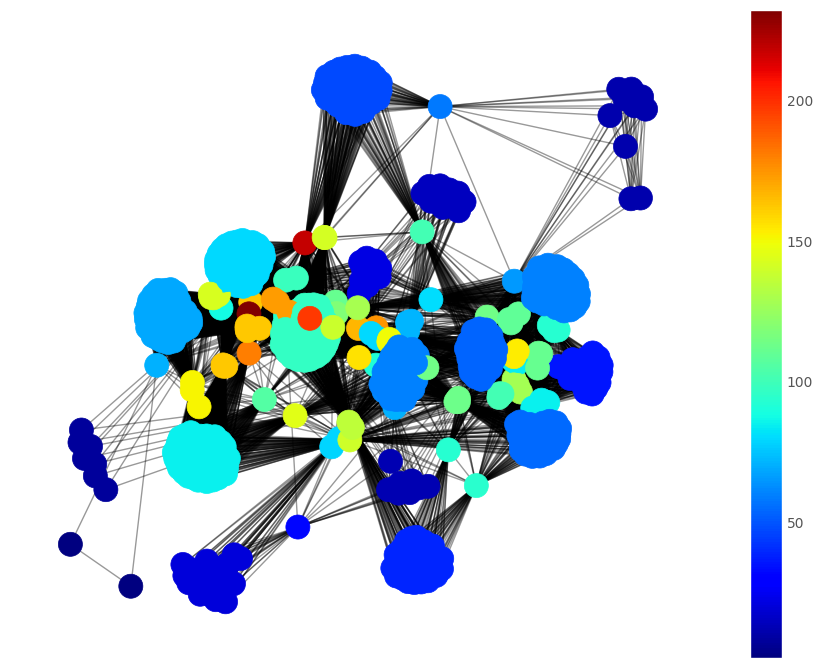

In [84]:
# the degree of network(G)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.degree(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
#nx.draw_networkx_labels(G, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.png', transparent=True,dpi=300)
plt.show()

## 2.2 Closeness Centrality 

In [85]:
oldC = nx.closeness_centrality(G)

- 10 vértices com maior Closeness

In [86]:
data_items = oldC.items()
data_list = list(data_items)
C = pd.DataFrame(data_list)
type(C)
C = C.set_axis(['Artist', 'Closeness'], axis=1, inplace=False)
C.nlargest(10, 'Closeness')[['Artist','Closeness']]

,Artist,Closeness
352,Feist,0.570234
532,The Black Keys,0.570234
36,blink-182,0.551334
173,Ed Sheeran,0.549114
194,Rihanna,0.549114
225,Bonobo,0.545164
474,The Goo Goo Dolls,0.544728
132,Vampire Weekend,0.540841
157,The Verve,0.540412
1,Beyoncé,0.538279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


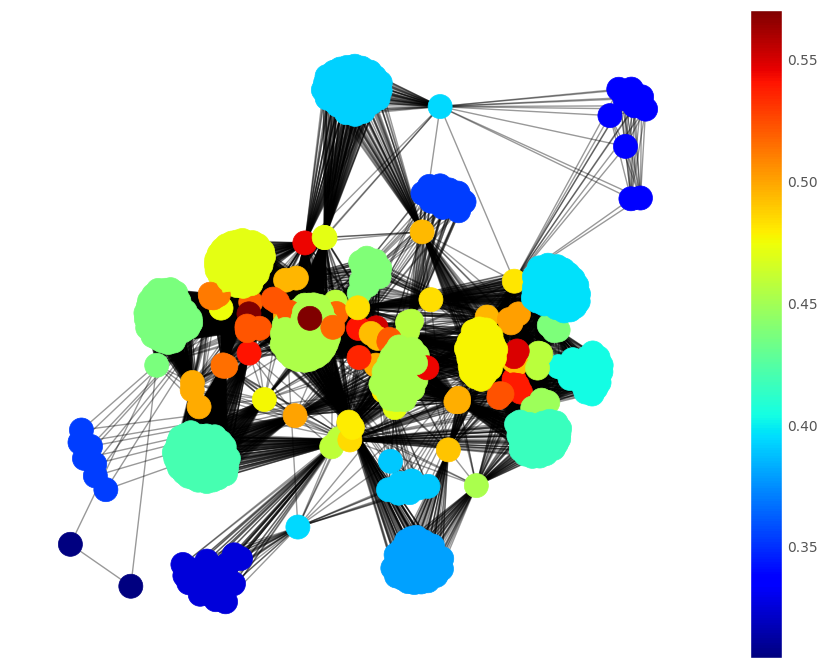

In [87]:
# the closeness centrality of network(G)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.closeness_centrality(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
#nx.draw_networkx_labels(G, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('closeness_centrality.png', transparent=True,dpi=600)
plt.show()

##2.3 Betweenness Centrality 

In [88]:
oldB = nx.betweenness_centrality(G)

- 10 vértices com maior Betweenness

In [89]:
data_items = oldB.items()
data_list = list(data_items)
B = pd.DataFrame(data_list)
type(B)
B = B.set_axis(['Artist', 'Betweenness'], axis=1, inplace=False)
B.nlargest(10, 'Betweenness')[['Artist','Betweenness']]

,Artist,Betweenness
225,Bonobo,0.068020
532,The Black Keys,0.062147
36,blink-182,0.054242
77,Etta James,0.053828
157,The Verve,0.038777
227,Charlie Puth,0.036064
95,Marcy Playground,0.034250
577,Mary Lambert,0.033303
184,Macklemore & Ryan Lewis,0.030786
352,Feist,0.029071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


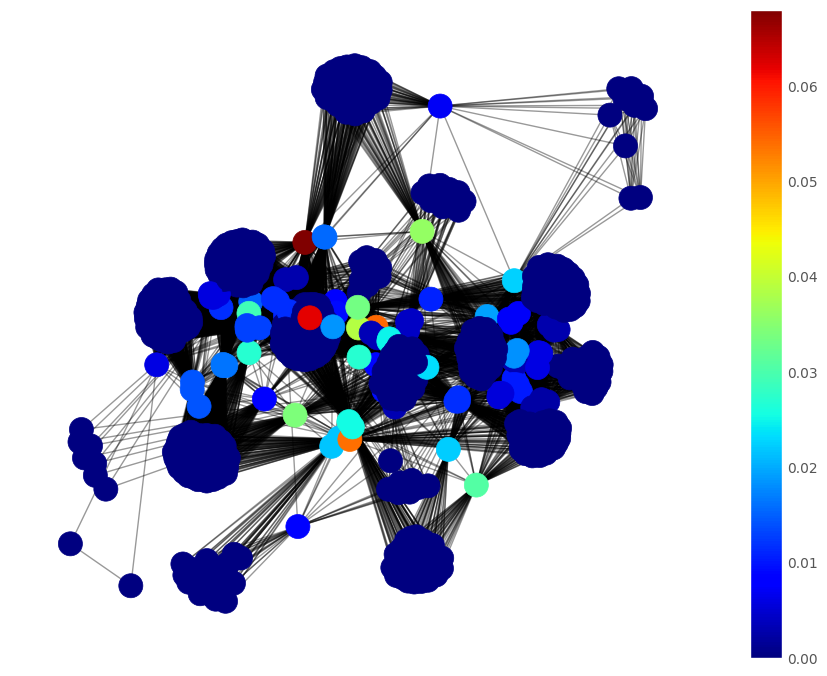

In [90]:
# the betwenness centrality of network(G)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
#nx.draw_networkx_labels(G, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.png', transparent=True,dpi=600)
plt.show()

##2.4 EigenVector Centrality 

In [91]:
oldE = nx.eigenvector_centrality(G)

- 10 vértices com maior Eigenvector

In [92]:
data_items = oldE.items()
data_list = list(data_items)
E = pd.DataFrame(data_list)
type(E)
E = E.set_axis(['Artist', 'EigenVector'], axis=1, inplace=False)
E.nlargest(10, 'EigenVector')[['Artist','EigenVector']]

,Artist,EigenVector
352,Feist,0.129513
225,Bonobo,0.119050
389,Phantogram,0.116488
396,Spoon,0.116488
403,The xx,0.116488
339,Burial,0.106800
372,Little Dragon,0.106800
375,Lykke Li,0.106800
404,Thievery Corporation,0.106800
157,The Verve,0.096270


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


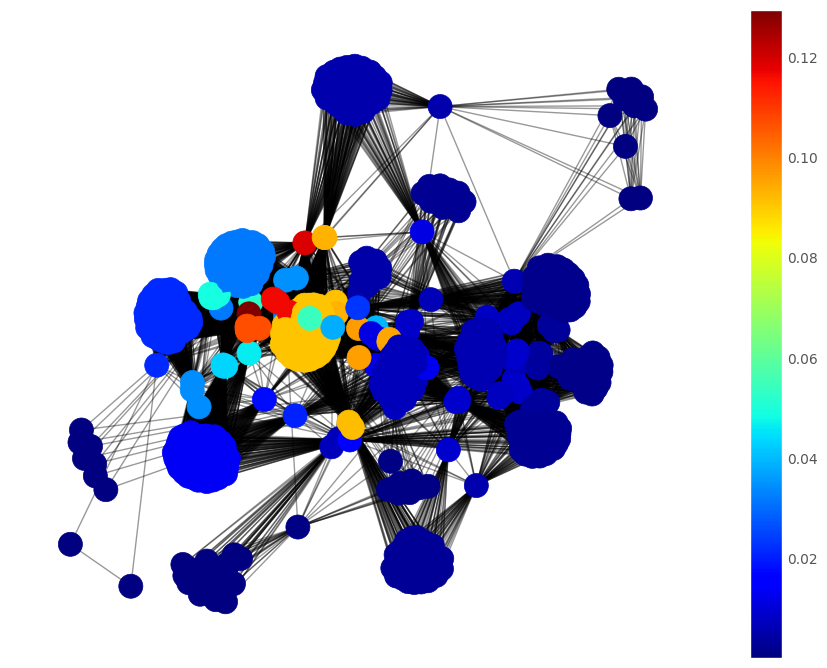

In [93]:
# the eigenvector centrality of network(G)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.eigenvector_centrality(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
#nx.draw_networkx_labels(G, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.png', transparent=True,dpi=600)
plt.show()

## Criando Dataframe com as novas métricas.

- Juntando os Dataframes.

In [94]:
df_DB = pd.merge(D,B, how = 'inner', on = 'Artist')
df_EC = pd.merge(E,C, how = 'inner', on = 'Artist')
df_final = pd.merge(df_DB,df_EC, how = 'inner', on = 'Artist')
df_final

,Artist,Degree,Betweenness,EigenVector,Closeness
0,Avril Lavigne,0.052786,0.000000,0.001540,0.404028
1,Beyoncé,0.187683,0.010316,0.008327,0.538279
2,Bowling For Soup,0.052786,0.000000,0.001540,0.404028
3,Boys Like Girls,0.052786,0.000000,0.001540,0.404028
4,Britney Spears,0.123167,0.003130,0.006944,0.491709
...,...,...,...,...,...
678,Tycho,0.101173,0.000000,0.021557,0.436620
679,Vacationer,0.101173,0.000000,0.021557,0.436620
680,Vetiver,0.101173,0.000000,0.021557,0.436620
681,Wilco,0.101173,0.000000,0.021557,0.436620


#3. Análise Bivariada 

In [95]:
g = G

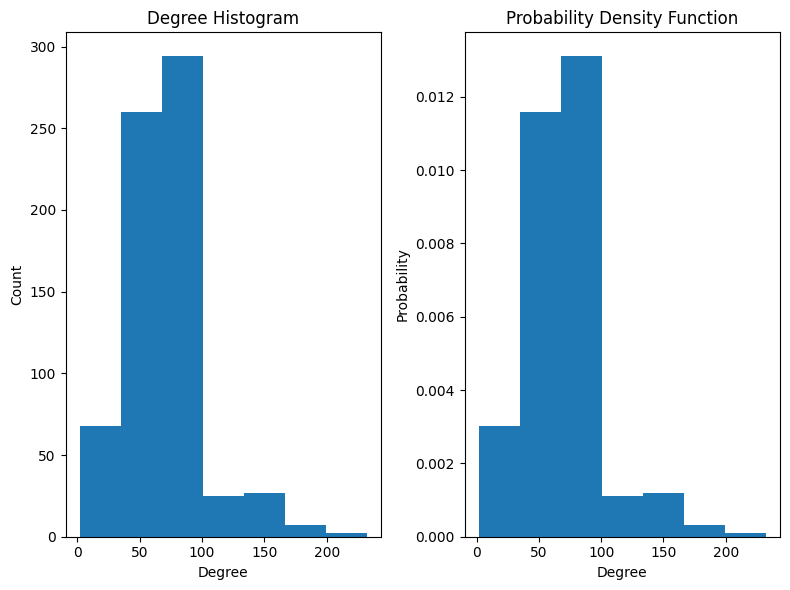

In [96]:
plt.style.use("default")
# degree sequence
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

fig, ax = plt.subplots(1,2,figsize=(8,6))

# all_data has information about degree_sequence and the width of each bin
all_data = ax[0].hist(degree_sequence,bins=7)
ax[1].hist(degree_sequence,bins=7,density=True)

ax[0].set_title("Degree Histogram")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Degree")

ax[1].set_title("Probability Density Function")
ax[1].set_ylabel("Probability")
ax[1].set_xlabel("Degree")

plt.tight_layout()
plt.show()

In [97]:
print(all_data)

(array([ 68., 260., 294.,  25.,  27.,   7.,   2.]), array([  2.        ,  34.85714286,  67.71428571, 100.57142857,
       133.42857143, 166.28571429, 199.14285714, 232.        ]), <BarContainer object of 7 artists>)


In [98]:
# print the width of each bin
print(all_data[1])

[  2.          34.85714286  67.71428571 100.57142857 133.42857143
 166.28571429 199.14285714 232.        ]


In [99]:
# calc the width of each bin using numpy
# diff calc the difference between two positions in the array
bin_width = np.diff(all_data[1])
bin_width

array([32.85714286, 32.85714286, 32.85714286, 32.85714286, 32.85714286,
       32.85714286, 32.85714286])

In [100]:
# total number of elements in array
all_data[0].sum()

683.0

In [101]:
# probability density function for each bin
# please check the right figure above and compare the results
all_data[0]/(all_data[0].sum() * bin_width)

array([3.03011013e-03, 1.15857152e-02, 1.31007703e-02, 1.11401108e-03,
       1.20313196e-03, 3.11923101e-04, 8.91208861e-05])

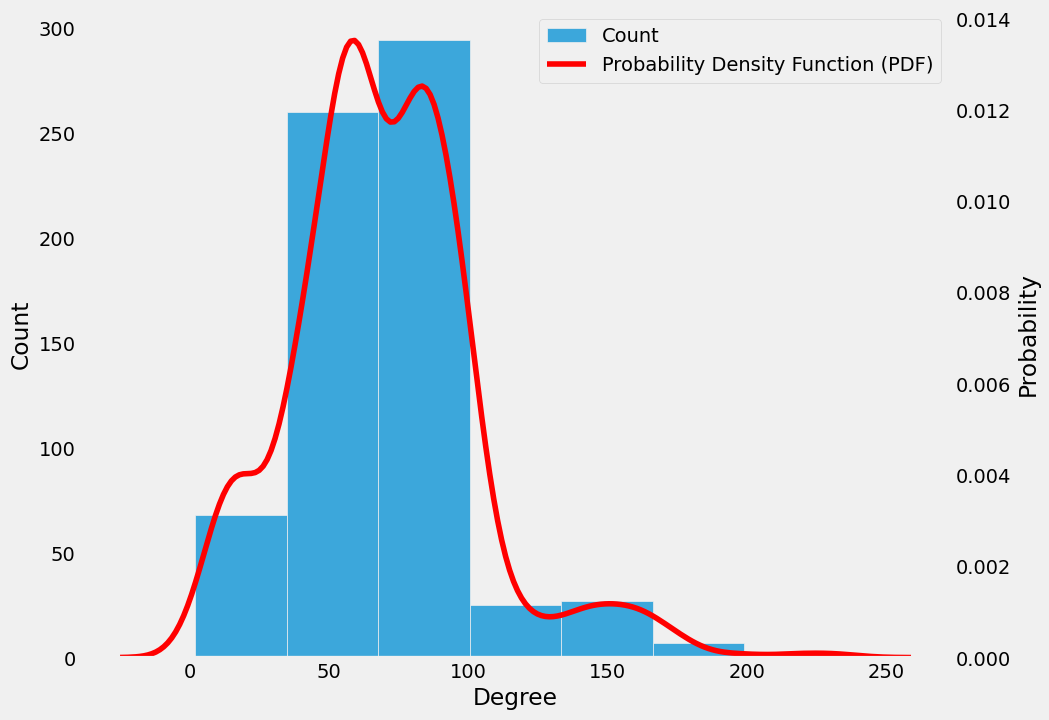

In [102]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

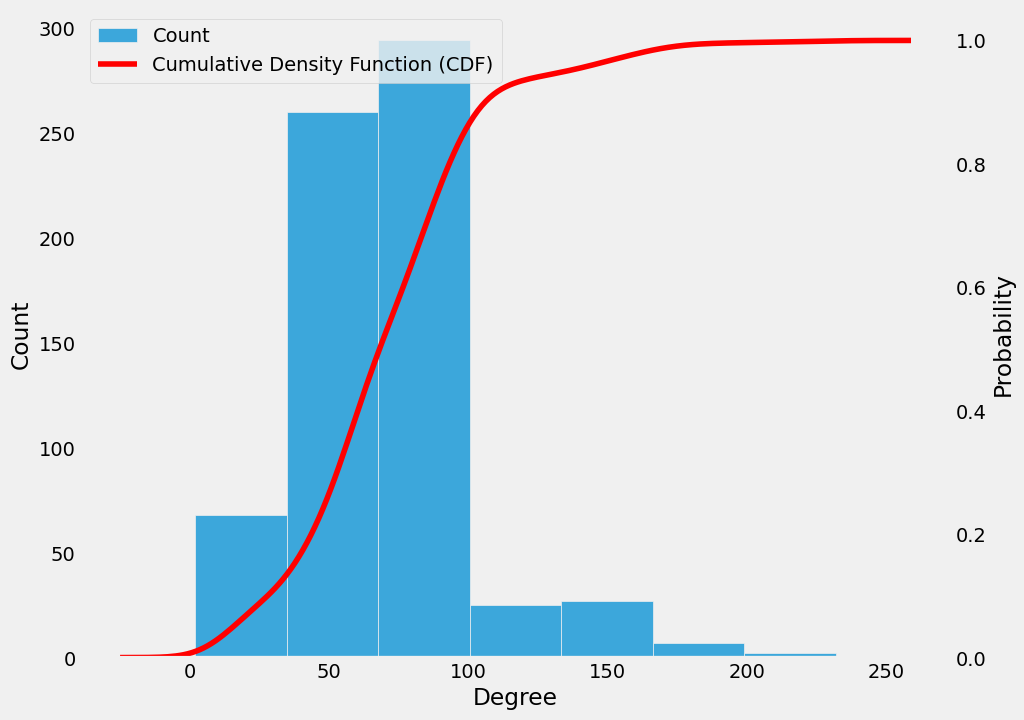

In [103]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

In [104]:
plt.style.use("ggplot")

# Another way to visualize the cumulative distribution
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

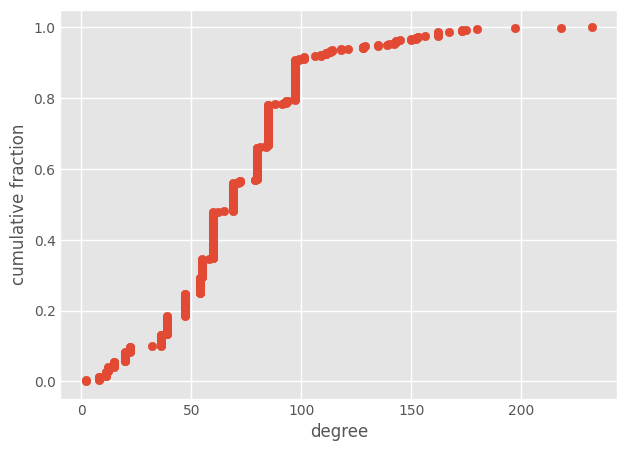

In [105]:
#
# insighs
# cdf(1) - almore 40% of vertices has degree 1
# cdf(2) P(degree <= 2) - 50% of vertices has at least degree 2 or less
# cdf(6) P(degree <= 6) - more than 95% of vertices has at least degree 6 or less
ecdf_degree(g)

# 4. Análise Multivariada 

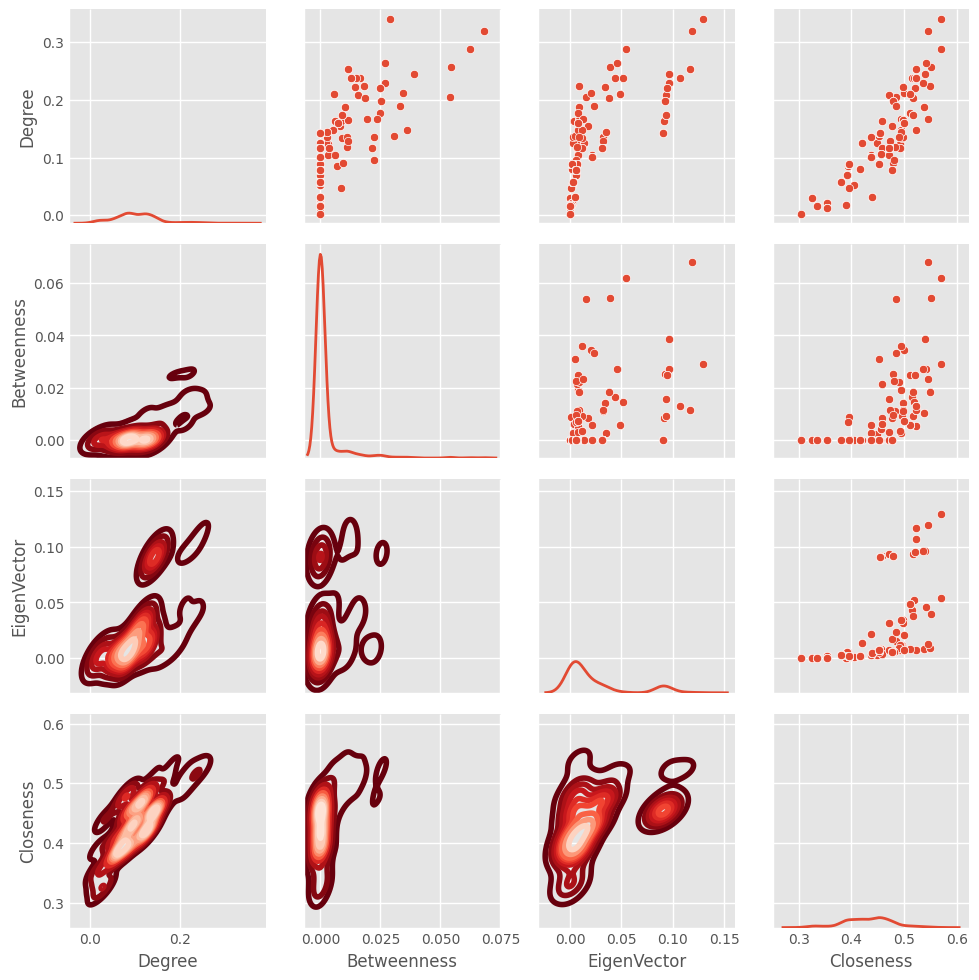

In [106]:
fig = sns.PairGrid(df_final)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

#5. Decomposição da Rede 

In [107]:
set([v for k,v in nx.core_number(G).items()])

{2, 8, 11, 12, 15, 20, 22, 36, 39, 47, 54, 55, 60, 69, 80, 85, 97}